### Automatic Questions tagging with NLP: Case of StackOvrFlow --- Exploratory Data Analysis

In [1]:
# Importing librairies
import pandas as pd
import nltk
import numpy as np
import pickle
from bs4 import BeautifulSoup
import stop_words
import re, sys
import spacy
import matplotlib.pyplot as plt
from time import sleep
from gensim.models import Phrases, phrases, coherencemodel
from gensim import models, corpora
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import warnings
warnings.filterwarnings('ignore')

C:\Users\mdegni\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Code for draw data
# SELECT  Body, Title, Tags FROM posts WHERE Id < 50000 and Tags is not null

### Importing necessary tools

In [3]:
# Loading CSV File
data = pd.read_csv('QueryResults.csv')
data.head(3)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,4,1,7.0,NaN,2008-07-31 21:42:52,NaN,564,36447.0,<p>I want to use a track-bar to change a form'...,8.0,...,Rich B,2018-07-02 17:55:27,2018-07-02 17:55:27,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,13.0,2,41.0,NaN,2012-10-31 16:42:47
1,6,1,31.0,NaN,2008-07-31 22:08:08,NaN,253,16153.0,<p>I have an absolutely positioned <code>div</...,9.0,...,Rich B,2016-03-19 06:05:48,2016-03-19 06:10:52,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>,5.0,0,10.0,NaN,NaN
2,7,2,NaN,4.0,2008-07-31 22:17:57,NaN,398,NaN,<p>An explicit cast to double like this isn't ...,9.0,...,NaN,2017-12-16 05:06:57,2017-12-16 05:06:57,NaN,NaN,NaN,0,NaN,NaN,NaN


In [4]:
data.shape

(27412, 22)

In [5]:
# Percentage of missing data by variable
data.isnull().sum().sort_values(ascending=False)*100/data.shape[0]

DeletionDate             100.000000
ClosedDate                97.336933
CommunityOwnedDate        94.786955
FavoriteCount             85.568364
AcceptedAnswerId          83.025682
ViewCount                 79.855538
AnswerCount               79.855538
Tags                      79.855538
Title                     79.855538
LastEditorDisplayName     76.444623
LastEditorUserId          59.787684
LastEditDate              59.357216
ParentId                  20.144462
OwnerDisplayName          15.828834
OwnerUserId                1.926164
Body                       0.000000
Score                      0.000000
CreationDate               0.000000
LastActivityDate           0.000000
CommentCount               0.000000
PostTypeId                 0.000000
Id                         0.000000
dtype: float64

Around 80% of Tags and Title are missing values. Body have any missing values. In this case, we think already to the semi-unsupervised machine learning.

In [6]:
data_imp = data[['Body','Title','Tags']].dropna()
data_imp.head()

,Body,Title,Tags
0,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...
1,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>
3,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>
4,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...
6,<p>Is there any standard way for a Web Server ...,Determine a User's Timezone,<javascript><html><browser><timezone><timezone...


In [7]:
# #delete all missing tags values
# data_imp1 = data_imp.dropna(axis=0, subset="Tags")

### Dealing with Tags

#### Tokenization 

In [8]:
# Def function for regular expressions
def reg_function(x):
    tokenizer = nltk.RegexpTokenizer(r'<.*?>')
    if x == x:
        x = tokenizer.tokenize(x.lower())
        for tag in range(len(x)):
            x[tag] = x[tag].strip('>').strip('<')
    return x

In [9]:
data_imp['token_tag'] = data_imp['Tags'].apply(reg_function)
data_imp['token_tag'].head()

0    [c#, floating-point, type-conversion, double, ...
1               [html, css, css3, internet-explorer-7]
3                                 [c#, .net, datetime]
4    [c#, datetime, time, datediff, relative-time-s...
6    [javascript, html, browser, timezone, timezone...
Name: token_tag, dtype: object

In [10]:
data_imp.head(3)

,Body,Title,Tags,token_tag
0,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,"[c#, floating-point, type-conversion, double, ..."
1,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>,"[html, css, css3, internet-explorer-7]"
3,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>,"[c#, .net, datetime]"


In [11]:
# EDA of tag
data_imp1 = data_imp.dropna(subset=['Tags'])
data_imp1.head()

,Body,Title,Tags,token_tag
0,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,"[c#, floating-point, type-conversion, double, ..."
1,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>,"[html, css, css3, internet-explorer-7]"
3,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>,"[c#, .net, datetime]"
4,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,"[c#, datetime, time, datediff, relative-time-s..."
6,<p>Is there any standard way for a Web Server ...,Determine a User's Timezone,<javascript><html><browser><timezone><timezone...,"[javascript, html, browser, timezone, timezone..."


In [12]:
def trans(val):
    val = " ".join(str(x) for x in val)
    return val

In [13]:
data_imp1['Token_tag'] = data_imp1['token_tag'].apply(trans)

In [25]:
# Méthode d'affichage des mots les plus utilisés
def word_occurrence(feature, top=20):
    count_keywords = dict()
    for row in feature:
        for word in row.split():
            if word in count_keywords:
                count_keywords[word] += 1
            else:
                count_keywords[word] = 1
    liste = []
    for k, v in count_keywords.items():
        liste.append([k,v])

    liste = sorted(liste, key=lambda x:x[1], reverse=True)
    print("Nombre de mots total : {} (pour {} lignes)".format(len(liste), feature.count()))

    plt.rc('font', weight='normal')
    fig, ax = plt.subplots(figsize=(15, 8))
    y_axis = [i[1] for i in liste[:top]]
    x_axis = [k for k,i in enumerate(liste[:top])]
    x_label = [i[0] for i in liste[:top]]
    plt.xticks(fontsize=15, rotation=90)
    plt.yticks(fontsize=13)
    plt.xticks(x_axis, x_label)
    plt.ylabel("Number of occurences", fontsize=18, labelpad=10)
    ax.bar(x_axis, y_axis, align='center', color='c')
    ax = plt.gca()
#    ax.invert_yaxis()
    
    plt.title("Words occurence : top"+str(top), bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
    plt.savefig('Frequent_tag.png',  bbox_inches='tight')
    plt.show()
   
    # On renvoie la liste triée par nombre d'occurrences
    return liste

Nombre de mots total : 2668 (pour 5522 lignes)


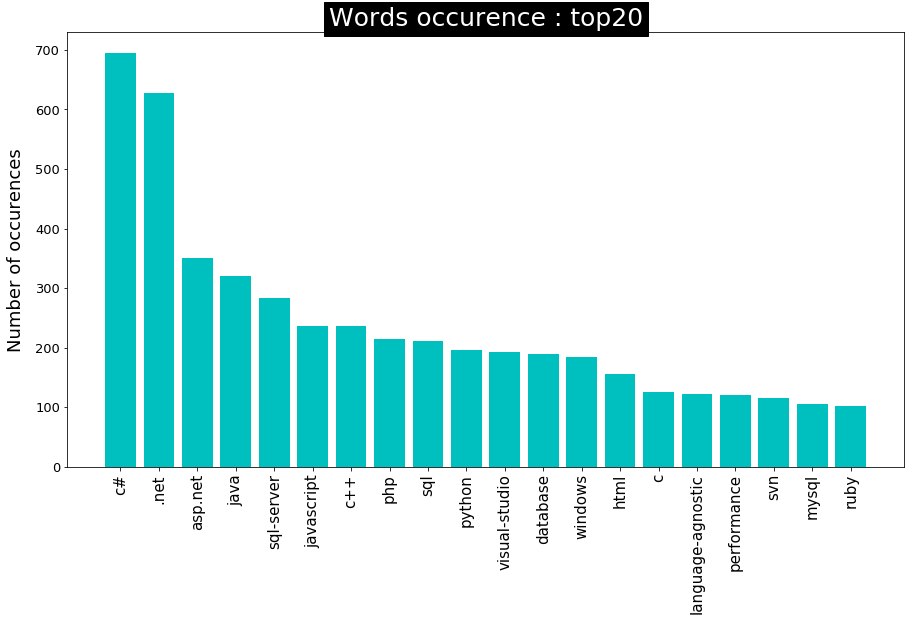

In [26]:
top_tag_sorted = word_occurrence(data_imp1['Token_tag'], top=20)


In [ ]:
plt.savefig('Frequent_tag.png')

In [49]:
top_tag_sorted[:50]

[['c#', 695],
 ['.net', 628],
 ['asp.net', 351],
 ['java', 320],
 ['sql-server', 284],
 ['javascript', 236],
 ['c++', 236],
 ['php', 214],
 ['sql', 211],
 ['python', 196],
 ['visual-studio', 193],
 ['database', 190],
 ['windows', 184],
 ['html', 156],
 ['c', 126],
 ['language-agnostic', 123],
 ['performance', 120],
 ['svn', 115],
 ['mysql', 106],
 ['ruby', 102],
 ['xml', 102],
 ['winforms', 102],
 ['linux', 98],
 ['version-control', 95],
 ['css', 93],
 ['unit-testing', 89],
 ['vb.net', 84],
 ['macos', 80],
 ['algorithm', 76],
 ['user-interface', 74],
 ['regex', 73],
 ['asp.net-mvc', 73],
 ['security', 71],
 ['web-services', 67],
 ['oop', 67],
 ['oracle', 63],
 ['testing', 62],
 ['sql-server-2005', 61],
 ['multithreading', 61],
 ['wpf', 60],
 ['linq', 58],
 ['visual-studio-2008', 58],
 ['ruby-on-rails', 57],
 ['unix', 56],
 ['.net-3.5', 54],
 ['jquery', 51],
 ['flex', 50],
 ['design', 47],
 ['networking', 47],
 ['string', 46]]

In [53]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [57]:
# Liste des tags triés par nombre d'apparition
save_object(top_tag_sorted, 'top_tags.pkl')

### Dealing with Body

In [34]:
pd.set_option('display.max_colwidth', -1)

In [35]:
from tqdm import tqdm, tqdm_notebook # progress bars in Jupyter
tqdm.pandas()
tqdm_notebook()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

0it [00:00, ?it/s]

In [36]:
data_imp.dropna(inplace=True)

In [37]:
data_imp[['Body','Title']].head()

,Body,Title
0,"<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n",Convert Decimal to Double?
1,"<p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href=""http://en.wikipedia.org/wiki/Internet_Explorer_7"" rel=""noreferrer"">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>\n\n<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>\n\n<ol>\n<li>Is there something I'm missing here?</li>\n<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the\nchild?</li>\n<li>Is there an area of the CSS specification that covers this?</li>\n</ol>\n",Percentage width child element in absolutely positioned parent on Internet Explorer 7
3,"<p>Given a <code>DateTime</code> representing a person's birthday, how do I calculate their age in years? </p>\n",How do I calculate someone's age in C#?
4,"<p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n\n<ul>\n<li>2 hours ago</li>\n<li>3 days ago</li>\n<li>a month ago</li>\n</ul>\n",Calculate relative time in C#
6,<p>Is there any standard way for a Web Server to be able to determine a user's timezone within a web page? </p>\n\n<p>Perhaps from an HTTP header or part of the user-agent string?</p>\n,Determine a User's Timezone


In [38]:
# Merge title and body
data_imp['Questions'] = data_imp['Title']+' '+data_imp['Body']
data_imp[['Questions']].head()

,Questions
0,"Convert Decimal to Double? <p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n"
1,"Percentage width child element in absolutely positioned parent on Internet Explorer 7 <p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href=""http://en.wikipedia.org/wiki/Internet_Explorer_7"" rel=""noreferrer"">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>\n\n<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>\n\n<ol>\n<li>Is there something I'm missing here?</li>\n<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the\nchild?</li>\n<li>Is there an area of the CSS specification that covers this?</li>\n</ol>\n"
3,"How do I calculate someone's age in C#? <p>Given a <code>DateTime</code> representing a person's birthday, how do I calculate their age in years? </p>\n"
4,"Calculate relative time in C# <p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n\n<ul>\n<li>2 hours ago</li>\n<li>3 days ago</li>\n<li>a month ago</li>\n</ul>\n"
6,Determine a User's Timezone <p>Is there any standard way for a Web Server to be able to determine a user's timezone within a web page? </p>\n\n<p>Perhaps from an HTTP header or part of the user-agent string?</p>\n


In [39]:
# Cleaning text
def virer(a,str1,str2): # Delete code windows
    a=a.split(str1)
    l=[]
    for i in range(len(a)):
        b=a[i].split(str2)
        l.append(b)
    for i in range(1,len(l)):
        l[i].remove(l[i][0])  
    s=""
    for i in range(len(l)):
        s+=l[i][0]
    return s

def get_text(x):
    x = str(x)
    x=virer(x, "<code>","</code>")
#     x = virer(x,"<blockquote>","</blockquote>")
    x = BeautifulSoup(x, 'lxml').get_text() # Get text in htlm with beautifulsoup
    tokenizer = nltk.RegexpTokenizer(r'\w+') # Use regular expression to delete \n
    x = tokenizer.tokenize(x.lower()) # apply on x by tranforming x in lower character
    return x

In [40]:
data_imp['token_questions'] = data_imp['Questions'].apply(get_text)
data_imp[['token_questions']].head()

,token_questions
0,"[convert, decimal, to, double, i, want, to, use, a, track, bar, to, change, a, form, s, opacity, this, is, my, code, when, i, build, the, application, it, gives, the, following, error, cannot, implicitly, convert, type, to, i, tried, using, and, but, then, the, control, doesn, t, work, this, code, worked, fine, in, a, past, vb, net, project]"
1,"[percentage, width, child, element, in, absolutely, positioned, parent, on, internet, explorer, 7, i, have, an, absolutely, positioned, containing, several, children, one, of, which, is, a, relatively, positioned, when, i, use, a, percentage, based, width, on, the, child, it, collapses, to, 0, width, on, internet, explorer, 7, but, not, on, firefox, or, safari, if, i, use, pixel, width, it, works, if, the, parent, is, relatively, positioned, the, percentage, width, on, the, child, works, is, there, something, i, m, missing, here, is, there, an, easy, fix, for, this, besides, the, pixel, based, width, on, the, child, is, there, an, area, of, the, ...]"
3,"[how, do, i, calculate, someone, s, age, in, c, given, a, representing, a, person, s, birthday, how, do, i, calculate, their, age, in, years]"
4,"[calculate, relative, time, in, c, given, a, specific, value, how, do, i, display, relative, time, like, 2, hours, ago, 3, days, ago, a, month, ago]"
6,"[determine, a, user, s, timezone, is, there, any, standard, way, for, a, web, server, to, be, able, to, determine, a, user, s, timezone, within, a, web, page, perhaps, from, an, http, header, or, part, of, the, user, agent, string]"


In [41]:
# Define stopwords
sw = stop_words.get_stop_words(language='en')

In [42]:
# Delete stopwords with 1-gram
data_imp['tokens_clean'] = data_imp.token_questions.map(
    lambda tok: [t.lower() for t in re.split(" ", re.sub(r"(\W+|_|\d+)", " ", " ".join(tok)))
                 if t.lower() not in sw and len(t) > 1]
)

In [43]:
data_imp[['tokens_clean']].head()

,tokens_clean
0,"[convert, decimal, double, want, use, track, bar, change, form, opacity, code, build, application, gives, following, error, implicitly, convert, type, tried, using, control, doesn, work, code, worked, fine, past, vb, net, project]"
1,"[percentage, width, child, element, absolutely, positioned, parent, internet, explorer, absolutely, positioned, containing, several, children, one, relatively, positioned, use, percentage, based, width, child, collapses, width, internet, explorer, firefox, safari, use, pixel, width, works, parent, relatively, positioned, percentage, width, child, works, something, missing, easy, fix, besides, pixel, based, width, child, area, css, specification, covers]"
3,"[calculate, someone, age, given, representing, person, birthday, calculate, age, years]"
4,"[calculate, relative, time, given, specific, value, display, relative, time, like, hours, ago, days, ago, month, ago]"
6,"[determine, user, timezone, standard, way, web, server, able, determine, user, timezone, within, web, page, perhaps, http, header, part, user, agent, string]"


In [44]:
# Lemmatization
lem = spacy.load('en_core_web_md')
data_imp['tokens_clean_lemma'] = data_imp.tokens_clean.progress_map(
    lambda x: [tok.lemma_ for tok in lem(' '.join(x))])
data_imp.head()


 10%|████████▏                                                                      | 568/5522 [00:17<03:23, 24.32it/s]


 21%|████████████████▏                                                             | 1146/5522 [00:34<01:53, 38.68it/s]


 32%|█████████████████████████▎                                                    | 1792/5522 [00:52<01:33, 39.71it/s]


 44%|██████████████████████████████████▍                                           | 2435/5522 [01:09<01:20, 38.51it/s]


 55%|███████████████████████████████████████████▎                                  | 3064/5522 [01:25<00:59, 41.64it/s]


 67%|████████████████████████████████████████████████████▏                         | 3693/5522 [01:42<00:51, 35.18it/s]


 79%|█████████████████████████████████████████████████████████████▍                | 4349/5522 [01:59<00:27, 42.54it/s]


 91%|██████████████████████████████████████████████████████████████████████▊       | 5010/5522 [02:16<00:14, 35.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 5522/5522 [02:29<00:00, 37.03it/s]

,Body,Title,Tags,token_tag,Questions,token_questions,tokens_clean,tokens_clean_lemma
0,"<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n",Convert Decimal to Double?,<c#><floating-point><type-conversion><double><decimal>,"[c#, floating-point, type-conversion, double, decimal]","Convert Decimal to Double? <p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n","[convert, decimal, to, double, i, want, to, use, a, track, bar, to, change, a, form, s, opacity, this, is, my, code, when, i, build, the, application, it, gives, the, following, error, cannot, implicitly, convert, type, to, i, tried, using, and, but, then, the, control, doesn, t, work, this, code, worked, fine, in, a, past, vb, net, project]","[convert, decimal, double, want, use, track, bar, change, form, opacity, code, build, application, gives, following, error, implicitly, convert, type, tried, using, control, doesn, work, code, worked, fine, past, vb, net, project]","[convert, decimal, double, want, use, track, bar, change, form, opacity, code, build, application, give, follow, error, implicitly, convert, type, try, use, control, doesn, work, code, work, fine, past, vb, net, project]"
1,"<p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href=""http://en.wikipedia.org/wiki/Internet_Explorer_7"" rel=""noreferrer"">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>\n\n<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>\n\n<ol>\n<li>Is there something I'm missing here?</li>\n<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the\nchild?</li>\n<li>Is there an area of the CSS specification that covers this?</li>\n</ol>\n",Percentage width child element in absolutely positioned parent on Internet Explorer 7,<html><css><css3><internet-explorer-7>,"[html, css, css3, internet-explorer-7]","Percentage width child element in absolutely positioned parent on Internet Explorer 7 <p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href=""http://en.wikipedia.org/wiki/Internet_Explorer_7"" rel=""noreferrer"">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>\n\n<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>\n\n<ol>\n<li>Is there something I'm missing here?</li>\n<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the\nchild?</li>\n<li>Is there an area of the CSS specification that covers this?</li>\n</ol>\n","[percentage, width, child, element, in, absolutely, positioned, parent, on, internet, explorer, 7, i

### Save data

In [45]:
data_imp.to_csv('request_tag.csv')